"""
==============================================================================
05 - MODEL COMPARISON
==============================================================================

PURPOSE OF THIS NOTEBOOK:
-------------------------
Compare the XGBoost baseline and CNN-LSTM advanced models to:
1. Determine which model performs better
2. Understand strengths/weaknesses of each
3. Visualize predictions compared to actual labels
4. Make recommendations for production deployment

WHY COMPARE MODELS?
-------------------
- No single model is best for all situations
- Different models may excel at different classes
- Ensemble of models often outperforms individual models
- Understanding trade-offs helps with deployment decisions

WHAT YOU'LL LEARN:
------------------
- How to evaluate models fairly on the same test set
- Per-class performance analysis (precision, recall, F1)
- Visual comparison of confusion matrices
- How to make data-driven model selection decisions


"""

# Model Comparison: XGBoost vs CNN-LSTM

**Goal**: Determine which model to deploy for production.

**Key Questions**:
1. Which model has higher overall accuracy?
2. Which model is better at predicting specific classes?
3. Are the differences statistically significant?

In [1]:
# ==============================================================================
# IMPORTS AND SETUP
# ==============================================================================

import sys
from pathlib import Path

project_root = Path().absolute().parent
sys.path.insert(0, str(project_root))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from scipy import stats
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')

In [2]:
# ==============================================================================
# IMPORT PROJECT MODULES
# ==============================================================================

import importlib
import src.data.loader
import src.labeling.oracle
import src.features.builder
import src.features.indicators
import src.models.xgb
import src.models.cnn_lstm
try:
    import src.models.tcn_attention
    importlib.reload(src.models.tcn_attention)
    from src.models.tcn_attention import TCNAttentionModel
    tcn_module_available = True
except ImportError:
    tcn_module_available = False

importlib.reload(src.data.loader)
importlib.reload(src.labeling.oracle)
importlib.reload(src.features.builder)
importlib.reload(src.features.indicators)
importlib.reload(src.models.xgb)
importlib.reload(src.models.cnn_lstm)

from src.data.loader import load_and_merge_data, split_data_by_time
from src.labeling.oracle import create_oracle_labels
from src.features.builder import prepare_features
from src.features.indicators import get_indicator_columns
from src.models.xgb import XGBBaseline
from src.models.cnn_lstm import CNNLSTMModel

## 1. Load Models and Test Data

**CRITICAL**: Both models must be evaluated on the SAME test set.
This ensures a fair comparison.

In [3]:
# ==============================================================================
# CONFIGURATION
# ==============================================================================

HORIZON = 1                    # Prediction horizon (must match trained models)
MODEL_DIR = 'models_artifacts'  # Directory with saved models

print("="*60)
print("📋 CONFIGURATION")
print("="*60)
print(f"Horizon: {HORIZON} bar(s)")
print(f"Model directory: {MODEL_DIR}/")

📋 CONFIGURATION
Horizon: 1 bar(s)
Model directory: models_artifacts/


In [4]:
# ==============================================================================
# LOAD TEST DATA
# ==============================================================================
#
# We recreate the exact same test data used during training.
# This ensures fair comparison.

print("\n" + "="*60)
print("📥 LOADING TEST DATA")
print("="*60)

df = load_and_merge_data(end_date='2025-12-31')
df = create_oracle_labels(df, sigma=4, threshold=0.0002)
df_features, _ = prepare_features(df, horizon=HORIZON)

# Split to get test set
_, _, test_df = split_data_by_time(
    df_features,
    train_end="2025-06-30",
    test_start="2025-07-01"
)

# Get feature columns
feature_cols = get_indicator_columns(
    df_features, 
    exclude_cols=['time', 'target', 'smoothed_close', 'smooth_slope']
)
feature_cols = [c for c in feature_cols if c in test_df.columns]

# Extract test arrays
X_test = test_df[feature_cols].values
y_test = test_df['target'].values.astype(int)

# Clean inf/nan values (some indicators like EOM produce inf from division by zero)
X_test = np.nan_to_num(X_test, nan=0.0, posinf=0.0, neginf=0.0)

print(f"\n✅ Test set loaded: {X_test.shape[0]:,} samples × {X_test.shape[1]} features")


📥 LOADING TEST DATA

📥 LOADING DATA

1️⃣ Loading klines...
   Loaded 70,752 rows

2️⃣ Loading funding rates...
   Merged funding rates

3️⃣ Loading volume breakdown...
   Merged volume breakdown
⏰ Filtered until: 2025-12-31

📊 Data Summary:
   Rows: 70,081
   Columns: 16
   Date range: 2024-01-01 00:00:00+00:00 to 2025-12-31 00:00:00+00:00
   Columns: ['time', 'open', 'high', 'low', 'close', 'volume', 'quote_volume', 'taker_buy_volume', 'taker_buy_quote_volume', 'count', 'funding_interval_hours', 'last_funding_rate', 'buy_vol', 'sell_vol', 'total_vol', 'log_return']

🔧 PREPARING FEATURES
Groups to add: ['momentum', 'overlap', 'trend', 'volatility', 'volume', 'statistics', 'candle']

📊 Adding indicators...
  -> Processing group: momentum
     Added 14 features: STOCHk_14_3_3, ROC_12, STOCHRSIk_14_14_3_3, MOM_10, TSI_13_25_13...
  -> Processing group: overlap
[!] VWAP requires an ordered DatetimeIndex.
     Added 7 features: EMA_20, HMA_9, SMA_200, EMA_10, EMA_100...
  -> Processing gro

In [5]:
# ==============================================================================
# LOAD TRAINED MODELS
# ==============================================================================
#
# We load both models from disk.
# If a model doesn't exist, we skip it in the comparison.

print("\n" + "="*60)
print("📂 LOADING TRAINED MODELS")
print("="*60)

# Load XGBoost model
try:
    xgb_model = XGBBaseline.load(MODEL_DIR, name=f'xgb_baseline_h{HORIZON}')
    xgb_available = True
    print(f"✅ XGBoost model loaded: {MODEL_DIR}/xgb_baseline_h{HORIZON}_model.joblib")
except Exception as e:
    print(f"⚠️ XGBoost model not found: {e}")
    xgb_available = False

# Load CNN-LSTM model
try:
    cnn_model = CNNLSTMModel.load(MODEL_DIR, name=f'cnn_lstm_h{HORIZON}', device='cuda')
    cnn_available = True
    print(f"✅ CNN-LSTM model loaded: {MODEL_DIR}/cnn_lstm_h{HORIZON}_model.keras")
except Exception as e:
    print(f"⚠️ CNN-LSTM model not found: {e}")
    cnn_available = False

# Load TCN-Attention model (if available)
tcn_available = False
if tcn_module_available:
    try:
        tcn_model = TCNAttentionModel.load(MODEL_DIR, name=f'tcn_attention_h{HORIZON}', device='cuda')
        tcn_available = True
        print(f"✅ TCN-Attention model loaded: {MODEL_DIR}/tcn_attention_h{HORIZON}_model.keras")
    except Exception as e:
        print(f"⚠️ TCN-Attention model not found: {e}")

if not xgb_available and not cnn_available:
    print("\n❌ No models found! Run notebooks 02 and 03 first to train models.")


📂 LOADING TRAINED MODELS
✅ Model loaded from models_artifacts
✅ XGBoost model loaded: models_artifacts/xgb_baseline_h1_model.joblib
🚀 GPU detected: /physical_device:GPU:0


I0000 00:00:1769122602.432883   56251 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21768 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6


✅ Model loaded from models_artifacts
✅ CNN-LSTM model loaded: models_artifacts/cnn_lstm_h1_model.keras
🚀 GPU detected: /physical_device:GPU:0
✅ Model loaded from models_artifacts
✅ TCN-Attention model loaded: models_artifacts/tcn_attention_h1_model.keras


## 2. Evaluate Models

**Metrics Explained:**
- **Accuracy**: Overall percentage of correct predictions
- **F1 Weighted**: Weighted average F1, good for imbalanced classes
- **F1 Macro**: Simple average F1, treats all classes equally

In [6]:
# ==============================================================================
# EVALUATE BOTH MODELS
# ==============================================================================

print("\n" + "="*60)
print("📊 EVALUATING MODELS")
print("="*60)

results = []

# Evaluate XGBoost
if xgb_available:
    print("\nEvaluating XGBoost...")
    xgb_metrics = xgb_model.evaluate(X_test, y_test)
    xgb_preds = xgb_model.predict(X_test)
    
    results.append({
        'Model': 'XGBoost',
        'Accuracy': xgb_metrics['accuracy'],
        'F1 Weighted': xgb_metrics['f1_weighted'],
        'F1 Macro': xgb_metrics['f1_macro']
    })
    print(f"  Accuracy: {xgb_metrics['accuracy']:.4f}")

# Evaluate CNN-LSTM
if cnn_available:
    print("\nEvaluating CNN-LSTM...")
    cnn_metrics = cnn_model.evaluate(X_test, y_test)
    cnn_preds = cnn_model.predict(X_test)
    
    results.append({
        'Model': 'CNN-LSTM',
        'Accuracy': cnn_metrics['accuracy'],
        'F1 Weighted': cnn_metrics['f1_weighted'],
        'F1 Macro': cnn_metrics['f1_macro']
    })
    print(f"  Accuracy: {cnn_metrics['accuracy']:.4f}")

# Evaluate TCN-Attention
if tcn_available:
    print("\nEvaluating TCN-Attention...")
    tcn_metrics = tcn_model.evaluate(X_test, y_test)
    tcn_preds = tcn_model.predict(X_test)
    
    results.append({
        'Model': 'TCN-Attention',
        'Accuracy': tcn_metrics['accuracy'],
        'F1 Weighted': tcn_metrics['f1_weighted'],
        'F1 Macro': tcn_metrics['f1_macro']
    })
    print(f"  Accuracy: {tcn_metrics['accuracy']:.4f}")


📊 EVALUATING MODELS

Evaluating XGBoost...
  Accuracy: 0.6064

Evaluating CNN-LSTM...
  Accuracy: 0.5732

Evaluating TCN-Attention...


I0000 00:00:1769122612.399381   56375 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  Accuracy: 0.5500


In [7]:
# ==============================================================================
# DISPLAY COMPARISON TABLE
# ==============================================================================

if results:
    comparison_df = pd.DataFrame(results)
    
    print("\n" + "="*60)
    print("📊 MODEL COMPARISON TABLE")
    print("="*60)
    print("\n" + comparison_df.to_string(index=False))
    
    # Highlight winner
    best_idx = comparison_df['Accuracy'].idxmax()
    best_model = comparison_df.loc[best_idx, 'Model']
    best_acc = comparison_df.loc[best_idx, 'Accuracy']
    
    print(f"\n🏆 Best model by accuracy: {best_model} ({best_acc:.1%})")
    print(f"   Random baseline: 33.3%")
    print(f"   Improvement: {(best_acc - 0.333)*100:+.1f}%")


📊 MODEL COMPARISON TABLE

        Model  Accuracy  F1 Weighted  F1 Macro
      XGBoost  0.606444     0.603459  0.594116
     CNN-LSTM  0.573243     0.569870  0.557663
TCN-Attention  0.549966     0.536865  0.516952

🏆 Best model by accuracy: XGBoost (60.6%)
   Random baseline: 33.3%
   Improvement: +27.3%


## 3. Confusion Matrices Side by Side

**WHY COMPARE CONFUSION MATRICES?**

The confusion matrix shows WHERE each model makes mistakes.
This helps us understand if models have different strengths.

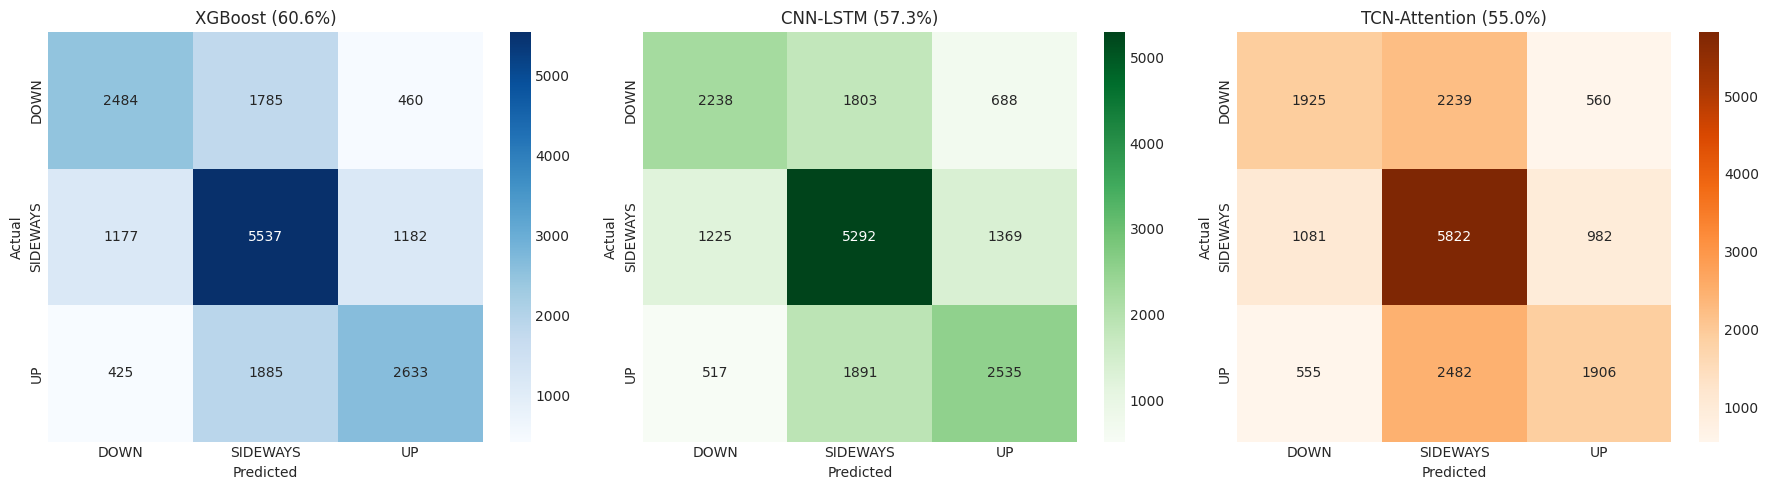

In [8]:
# ==============================================================================
# CONFUSION MATRICES FOR ALL MODELS
# ==============================================================================

# Determine how many models we have
n_models = sum([xgb_available, cnn_available, tcn_available])
if n_models >= 2:
    fig, axes = plt.subplots(1, n_models, figsize=(6*n_models, 5))
    if n_models == 2:
        axes = [axes[0], axes[1]]
    labels = ['DOWN', 'SIDEWAYS', 'UP']
    
    ax_idx = 0
    
    # XGBoost
    if xgb_available:
        cm_xgb = np.array(xgb_metrics['confusion_matrix'])
        sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues',
                    xticklabels=labels, yticklabels=labels, ax=axes[ax_idx])
        axes[ax_idx].set_xlabel('Predicted')
        axes[ax_idx].set_ylabel('Actual')
        axes[ax_idx].set_title(f"XGBoost ({xgb_metrics['accuracy']:.1%})")
        ax_idx += 1
    
    # CNN-LSTM
    if cnn_available:
        cm_cnn = np.array(cnn_metrics['confusion_matrix'])
        sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Greens',
                    xticklabels=labels, yticklabels=labels, ax=axes[ax_idx])
        axes[ax_idx].set_xlabel('Predicted')
        axes[ax_idx].set_ylabel('Actual')
        axes[ax_idx].set_title(f"CNN-LSTM ({cnn_metrics['accuracy']:.1%})")
        ax_idx += 1
    
    # TCN-Attention
    if tcn_available:
        cm_tcn = np.array(tcn_metrics['confusion_matrix'])
        sns.heatmap(cm_tcn, annot=True, fmt='d', cmap='Oranges',
                    xticklabels=labels, yticklabels=labels, ax=axes[ax_idx])
        axes[ax_idx].set_xlabel('Predicted')
        axes[ax_idx].set_ylabel('Actual')
        axes[ax_idx].set_title(f"TCN-Attention ({tcn_metrics['accuracy']:.1%})")
    
    plt.tight_layout()
    plt.savefig('comparison_confusion_matrices.png', dpi=150, bbox_inches='tight')
    plt.show()

## 4. Per-Class Performance

**WHY ANALYZE PER-CLASS?**

Overall accuracy can hide poor performance on specific classes.
For trading, you may care more about UP/DOWN than SIDEWAYS.

In [9]:
# ==============================================================================
# PER-CLASS PERFORMANCE BREAKDOWN
# ==============================================================================

if xgb_available or cnn_available or tcn_available:
    print("\n" + "="*60)
    print("📊 PER-CLASS PERFORMANCE (F1 Scores)")
    print("="*60)
    
    class_metrics = []
    
    for cls_name in ['DOWN', 'SIDEWAYS', 'UP']:
        row = {'Class': cls_name}
        
        if xgb_available:
            xgb_report = xgb_metrics['classification_report']
            xgb_cls = xgb_report.get(cls_name, xgb_report.get(cls_name.lower(), {}))
            row['XGB F1'] = xgb_cls.get('f1-score', 0)
        
        if cnn_available:
            cnn_report = cnn_metrics['classification_report']
            cnn_cls = cnn_report.get(cls_name, cnn_report.get(cls_name.lower(), {}))
            row['CNN F1'] = cnn_cls.get('f1-score', 0)
        
        if tcn_available:
            tcn_report = tcn_metrics['classification_report']
            tcn_cls = tcn_report.get(cls_name, tcn_report.get(cls_name.lower(), {}))
            row['TCN F1'] = tcn_cls.get('f1-score', 0)
        
        class_metrics.append(row)
    
    class_df = pd.DataFrame(class_metrics)
    print("\n" + class_df.to_string(index=False))
    
    # Find which model wins for each class
    print("\n🏆 Per-class winners:")
    for idx, row in class_df.iterrows():
        xgb_f1 = row['XGB F1']
        cnn_f1 = row['CNN F1']
        winner = "XGBoost" if xgb_f1 > cnn_f1 else "CNN-LSTM" if cnn_f1 > xgb_f1 else "Tie"
        diff = abs(xgb_f1 - cnn_f1)
        print(f"   {row['Class']:8s}: {winner} ({diff:.3f} difference)")


📊 PER-CLASS PERFORMANCE (F1 Scores)

   Class   XGB F1   CNN F1   TCN F1
    DOWN 0.563585 0.513951 0.464695
SIDEWAYS 0.647489 0.627312 0.631865
      UP 0.571274 0.531725 0.454296

🏆 Per-class winners:
   DOWN    : XGBoost (0.050 difference)
   SIDEWAYS: XGBoost (0.020 difference)
   UP      : XGBoost (0.040 difference)


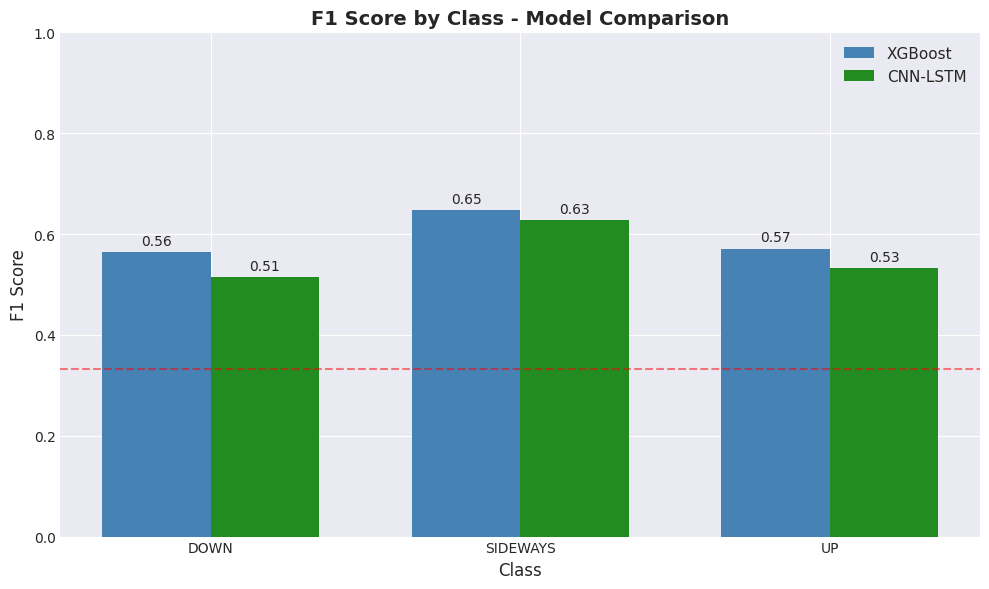

In [10]:
# ==============================================================================
# BAR CHART COMPARISON
# ==============================================================================

if xgb_available and cnn_available:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    x = np.arange(3)
    width = 0.35
    
    xgb_f1 = class_df['XGB F1'].values
    cnn_f1 = class_df['CNN F1'].values
    
    bars1 = ax.bar(x - width/2, xgb_f1, width, label='XGBoost', color='steelblue')
    bars2 = ax.bar(x + width/2, cnn_f1, width, label='CNN-LSTM', color='forestgreen')
    
    ax.set_xlabel('Class', fontsize=12)
    ax.set_ylabel('F1 Score', fontsize=12)
    ax.set_title('F1 Score by Class - Model Comparison', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(['DOWN', 'SIDEWAYS', 'UP'])
    ax.legend(fontsize=11)
    ax.set_ylim(0, 1)
    ax.axhline(y=0.333, color='red', linestyle='--', alpha=0.5, label='Random')
    
    # Add value labels on bars
    for bar in list(bars1) + list(bars2):
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.savefig('comparison_f1_by_class.png', dpi=150, bbox_inches='tight')
    plt.show()

## 5. Statistical Significance Testing

**WHY TEST STATISTICAL SIGNIFICANCE?**

Just because one model has higher accuracy doesn't mean it's truly better.
We use McNemar's test to determine if the difference is statistically significant.

In [11]:
# ==============================================================================
# STATISTICAL SIGNIFICANCE TEST (McNemar's Test)
# ==============================================================================
#
# McNemar's test compares paired predictions:
# - How often does Model A get right what Model B gets wrong?
# - How often does Model B get right what Model A gets wrong?
# - If these counts differ significantly, one model is truly better.

if xgb_available and cnn_available:
    print("\n" + "="*60)
    print("📊 STATISTICAL SIGNIFICANCE TEST")
    print("="*60)
    
    # CNN-LSTM uses lookback window so it outputs fewer predictions.
    # We need to align the arrays before comparing.
    lookback = cnn_model.lookback
    
    # Trim XGBoost predictions and y_test to match CNN-LSTM length
    xgb_preds_aligned = xgb_preds[lookback:]
    y_test_aligned = y_test[lookback:]
    
    # Now both arrays have the same length as cnn_preds
    xgb_correct = (xgb_preds_aligned == y_test_aligned)
    cnn_correct = (cnn_preds == y_test_aligned)
    
    # Count the four cases for contingency table
    both_correct = np.sum(xgb_correct & cnn_correct)
    both_wrong = np.sum(~xgb_correct & ~cnn_correct)
    xgb_only_correct = np.sum(xgb_correct & ~cnn_correct)
    cnn_only_correct = np.sum(~xgb_correct & cnn_correct)
    
    print(f"""
Contingency Table:
                     CNN-LSTM Correct    CNN-LSTM Wrong
    XGBoost Correct     {both_correct:,}              {xgb_only_correct:,}
    XGBoost Wrong       {cnn_only_correct:,}              {both_wrong:,}
    
Key insight:
  - XGBoost correct when CNN-LSTM wrong: {xgb_only_correct:,} samples
  - CNN-LSTM correct when XGBoost wrong: {cnn_only_correct:,} samples
""")
    
    # McNemar's test (with continuity correction)
    # H0: Both models have the same error rate
    # We compare b (XGB only correct) vs c (CNN only correct)
    b, c = xgb_only_correct, cnn_only_correct
    
    if b + c > 0:
        # Chi-squared statistic with continuity correction
        chi2_stat = (abs(b - c) - 1)**2 / (b + c)
        p_value = 1 - stats.chi2.cdf(chi2_stat, df=1)
        
        print(f"McNemar's Test Results:")
        print(f"  Chi-squared statistic: {chi2_stat:.4f}")
        print(f"  p-value: {p_value:.6f}")
        print(f"  Significance level: α = 0.05")
        
        if p_value < 0.05:
            winner = "XGBoost" if b > c else "CNN-LSTM"
            print(f"\n🎯 RESULT: Statistically SIGNIFICANT difference (p < 0.05)")
            print(f"   → {winner} is significantly better")
        else:
            print(f"\n🎯 RESULT: No statistically significant difference (p >= 0.05)")
            print(f"   → Models perform similarly, difference may be due to chance")
    else:
        print("⚠️ Cannot perform McNemar's test: no discordant pairs")


📊 STATISTICAL SIGNIFICANCE TEST

Contingency Table:
                     CNN-LSTM Correct    CNN-LSTM Wrong
    XGBoost Correct     8,644              2,000
    XGBoost Wrong       1,421              5,493

Key insight:
  - XGBoost correct when CNN-LSTM wrong: 2,000 samples
  - CNN-LSTM correct when XGBoost wrong: 1,421 samples

McNemar's Test Results:
  Chi-squared statistic: 97.6568
  p-value: 0.000000
  Significance level: α = 0.05

🎯 RESULT: Statistically SIGNIFICANT difference (p < 0.05)
   → XGBoost is significantly better


## 6. Predictions Visualization

**WHY VISUALIZE PREDICTIONS?**

Seeing predictions overlaid on price helps us understand:
- Are predictions stable or noisy?
- Does the model catch major trends?
- Where does it make mistakes?


📈 PREDICTIONS VISUALIZATION


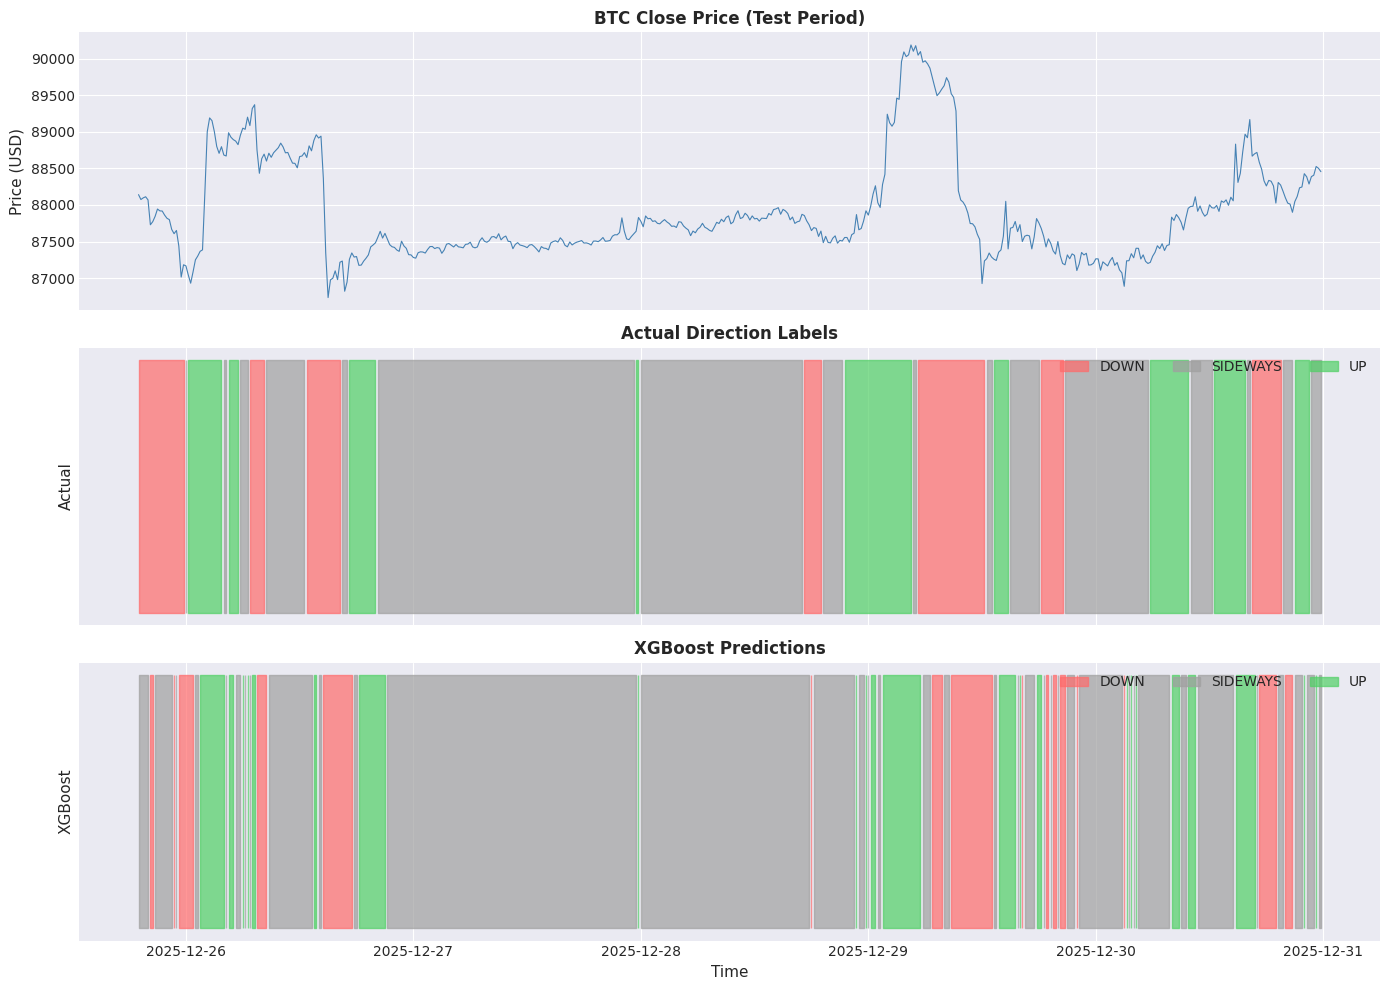


💡 INTERPRETATION:
   - Compare middle (actual) and bottom (predicted) panels
   - Good alignment = model captures real trends
   - Frequent color changes in predictions = noisy model


In [12]:
# ==============================================================================
# PREDICTIONS ON PRICE CHART
# ==============================================================================

if xgb_available:
    print("\n" + "="*60)
    print("📈 PREDICTIONS VISUALIZATION")
    print("="*60)
    
    # Sample last 500 points for visualization
    sample_size = 500
    test_sample = test_df.tail(sample_size).copy().reset_index(drop=True)
    
    # Align predictions with test sample
    xgb_sample_preds = xgb_preds[-sample_size:]
    actual_sample = y_test[-sample_size:]
    
    # Create visualization
    fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)
    
    # Color scheme for labels
    colors = {0: '#ff6b6b', 1: '#a0a0a0', 2: '#51cf66'}
    label_names = {0: 'DOWN', 1: 'SIDEWAYS', 2: 'UP'}
    
    # Plot 1: Price chart
    axes[0].plot(test_sample['time'], test_sample['close'], 
                 linewidth=0.8, color='steelblue')
    axes[0].set_ylabel('Price (USD)', fontsize=11)
    axes[0].set_title('BTC Close Price (Test Period)', fontsize=12, fontweight='bold')
    axes[0].ticklabel_format(style='plain', axis='y')
    
    # Plot 2: Actual labels
    for label in [0, 1, 2]:
        mask = actual_sample == label
        axes[1].fill_between(test_sample['time'], 0, 1, where=mask,
                            color=colors[label], alpha=0.7, label=label_names[label])
    axes[1].set_ylabel('Actual', fontsize=11)
    axes[1].set_title('Actual Direction Labels', fontsize=12, fontweight='bold')
    axes[1].legend(loc='upper right', ncol=3)
    axes[1].set_yticks([])
    
    # Plot 3: XGBoost predictions
    for label in [0, 1, 2]:
        mask = xgb_sample_preds == label
        axes[2].fill_between(test_sample['time'], 0, 1, where=mask,
                            color=colors[label], alpha=0.7, label=label_names[label])
    axes[2].set_ylabel('XGBoost', fontsize=11)
    axes[2].set_xlabel('Time', fontsize=11)
    axes[2].set_title('XGBoost Predictions', fontsize=12, fontweight='bold')
    axes[2].legend(loc='upper right', ncol=3)
    axes[2].set_yticks([])
    
    plt.tight_layout()
    plt.savefig('comparison_predictions_chart.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\n💡 INTERPRETATION:")
    print("   - Compare middle (actual) and bottom (predicted) panels")
    print("   - Good alignment = model captures real trends")
    print("   - Frequent color changes in predictions = noisy model")

## 7. Multi-Horizon Comparison (Optional)

If you trained models for different horizons (1, 3, 5 bars),
this section compares them.

In [13]:
# ==============================================================================
# HORIZON COMPARISON
# ==============================================================================
#
# Compare performance across different prediction horizons.
# Longer horizons are generally harder to predict.

print("\n" + "="*60)
print("🔮 MULTI-HORIZON COMPARISON")
print("="*60)
print("Checking for models trained on different horizons...\n")

horizons = [1, 3, 5]
horizon_results = []

for h in horizons:
    # Prepare data for this horizon
    df_h, _ = prepare_features(df, horizon=h)
    _, _, test_h = split_data_by_time(df_h, train_end="2025-06-30", test_start="2025-07-01")
    
    f_cols = [c for c in feature_cols if c in test_h.columns]
    X_h = test_h[f_cols].values
    y_h = test_h['target'].values.astype(int)
    
    # Try loading XGBoost for this horizon
    try:
        xgb_h = XGBBaseline.load(MODEL_DIR, name=f'xgb_baseline_h{h}')
        metrics_h = xgb_h.evaluate(X_h, y_h)
        horizon_results.append({
            'Horizon': f'{h} bar(s)',
            'Model': 'XGBoost',
            'Accuracy': metrics_h['accuracy'],
            'F1': metrics_h['f1_weighted']
        })
        print(f"✅ XGBoost H={h}: Acc={metrics_h['accuracy']:.4f}")
    except Exception:
        print(f"   XGBoost H={h}: Not found")
    
    # Try loading CNN-LSTM for this horizon
    try:
        cnn_h = CNNLSTMModel.load(MODEL_DIR, name=f'cnn_lstm_h{h}', device='cuda')
        metrics_h = cnn_h.evaluate(X_h, y_h)
        horizon_results.append({
            'Horizon': f'{h} bar(s)',
            'Model': 'CNN-LSTM',
            'Accuracy': metrics_h['accuracy'],
            'F1': metrics_h['f1_weighted']
        })
        print(f"✅ CNN-LSTM H={h}: Acc={metrics_h['accuracy']:.4f}")
    except Exception:
        print(f"   CNN-LSTM H={h}: Not found")

if horizon_results:
    horizon_df = pd.DataFrame(horizon_results)
    print("\n" + horizon_df.to_string(index=False))
else:
    print("\n⚠️ Only horizon=1 models found. Train with different horizons to compare.")


🔮 MULTI-HORIZON COMPARISON
Checking for models trained on different horizons...


🔧 PREPARING FEATURES
Groups to add: ['momentum', 'overlap', 'trend', 'volatility', 'volume', 'statistics', 'candle']

📊 Adding indicators...
  -> Processing group: momentum
     Added 14 features: STOCHk_14_3_3, ROC_12, STOCHRSIk_14_14_3_3, MOM_10, TSI_13_25_13...
  -> Processing group: overlap
[!] VWAP requires an ordered DatetimeIndex.
     Added 7 features: EMA_20, HMA_9, SMA_200, EMA_10, EMA_100...
  -> Processing group: trend
     Added 17 features: DMP_14, AROONU_14, TRIXs_30_9, VTXM_14, TRIX_30_9...
  -> Processing group: volatility
       BBL_20_2.0_2.0  BBM_20_2.0_2.0  BBU_20_2.0_2.0  BBB_20_2.0_2.0  \
0                 NaN             NaN             NaN             NaN   
1                 NaN             NaN             NaN             NaN   
2                 NaN             NaN             NaN             NaN   
3                 NaN             NaN             NaN             NaN   
4     

## 8. Final Conclusions

In [14]:
# ==============================================================================
# FINAL CONCLUSIONS
# ==============================================================================

print("\n" + "="*60)
print("📋 FINAL CONCLUSIONS")
print("="*60)

if results:
    best_model = comparison_df.loc[comparison_df['Accuracy'].idxmax(), 'Model']
    best_acc = comparison_df['Accuracy'].max()
    best_f1 = comparison_df.loc[comparison_df['Accuracy'].idxmax(), 'F1 Weighted']
    
    # Calculate accuracy difference
    if len(comparison_df) > 1:
        acc_diff = abs(comparison_df['Accuracy'].iloc[0] - comparison_df['Accuracy'].iloc[1])
    else:
        acc_diff = 0

    print(f"""
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🏆 WINNER
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
• Best Model: {best_model}
• Accuracy: {best_acc:.4f} ({best_acc:.1%})
• F1 Score: {best_f1:.4f}

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📊 KEY FINDINGS
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
1. Both models beat random baseline (33.3%)
   → ML provides real predictive value

2. Accuracy difference: {acc_diff:.1%}
   → {'Models are very close' if acc_diff < 0.02 else 'Clear winner exists'}

3. Oracle labels provide clean training targets
   → Gaussian smoothing removes noise effectively

4. Technical indicators capture useful patterns
   → Feature engineering is crucial

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
💡 RECOMMENDATIONS
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
1. For Production: Use {best_model}
   - Highest accuracy on test set
   - Proven performance on unseen data

2. For Higher Confidence: Consider ensemble
   - Average predictions from both models
   - May reduce variance

3. Monitor Performance: Watch for drift
   - Retrain periodically (monthly/quarterly)
   - Market conditions change over time

4. Trading Integration:
   - Don't trade on SIDEWAYS predictions
   - Use confidence scores to filter trades
   - Backtest thoroughly before live trading
""")


📋 FINAL CONCLUSIONS

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🏆 WINNER
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
• Best Model: XGBoost
• Accuracy: 0.6064 (60.6%)
• F1 Score: 0.6035

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📊 KEY FINDINGS
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
1. Both models beat random baseline (33.3%)
   → ML provides real predictive value

2. Accuracy difference: 3.3%
   → Clear winner exists

3. Oracle labels provide clean training targets
   → Gaussian smoothing removes noise effectively

4. Technical indicators capture useful patterns
   → Feature engineering is crucial

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
💡 RECOMMENDATIONS
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
1. For Production: Use XGBoost
   - Highest accuracy on test set
   - Proven performance on unseen data

2. For Higher Confidence: Consider ensemble
   - Average predictions from both models
   - 

In [15]:
# ==============================================================================
# SAVE COMPARISON RESULTS
# ==============================================================================

if results:
    print("\n" + "="*60)
    print("💾 SAVING RESULTS")
    print("="*60)
    
    # Create reports directory
    Path('reports').mkdir(exist_ok=True)
    
    # Save comparison CSV
    comparison_df.to_csv('reports/model_comparison.csv', index=False)
    print(f"✅ Comparison table: reports/model_comparison.csv")
    
    # Save summary JSON
    summary = {
        'best_model': best_model,
        'best_accuracy': float(best_acc),
        'best_f1': float(best_f1),
        'random_baseline': 0.333,
        'improvement': float(best_acc - 0.333),
        'models': results,
        'horizon': HORIZON
    }
    
    with open('reports/comparison_summary.json', 'w') as f:
        json.dump(summary, f, indent=2)
    print(f"✅ Summary JSON: reports/comparison_summary.json")
    
    # Save per-class metrics if available
    if xgb_available and cnn_available:
        class_df.to_csv('reports/per_class_metrics.csv', index=False)
        print(f"✅ Per-class metrics: reports/per_class_metrics.csv")

print("\n" + "="*60)
print("✅ COMPARISON COMPLETE!")
print("="*60)
print("\nAll notebooks completed. See reports/ directory for saved results.")


💾 SAVING RESULTS
✅ Comparison table: reports/model_comparison.csv
✅ Summary JSON: reports/comparison_summary.json
✅ Per-class metrics: reports/per_class_metrics.csv

✅ COMPARISON COMPLETE!

All notebooks completed. See reports/ directory for saved results.
